<h3><Center> Importing Necessary Libraries

In [118]:
# Import libraries
import pandas as pd

# os path
import os, os.path
from os.path import exists as file_exists

# web scraping 
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options

# plotting
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# date and time library
from datetime import date as dt

# parse 
from ast import parse

# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Warning settings
import warnings
warnings.filterwarnings("ignore")

# kernel reload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h5> URLs

In [119]:
url_list = [
   'https://finviz.com/quote.ashx?t=TSLA', # Tesla
   'https://finviz.com/quote.ashx?t=META', # Meta
   'https://finviz.com/quote.ashx?t=NFLX', # Netflix
   'https://finviz.com/quote.ashx?t=AAPL'  # AAPL  
   ] 

<h3><Center> Driver Configuration </h3>

In [120]:
import chromedriver_autoinstaller as chromedriver
chromedriver.install()

'd:\\Documents\\venv\\lib\\site-packages\\chromedriver_autoinstaller\\104\\chromedriver.exe'

In [122]:
'''
VADER (Valence Aware Dictionary and Sentiment Reasoner) -- a lexicon and rulebased sentiment analysis.

VADER's SentimentAnalysisANalyzer() takes in a string and returns a dictionary of scores in each of the
four categories: {negative, positive, neutral, compound}
'''


# Updated words and values
new_words = {
    'Mega-Growth': 50,
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'down': -15,
    'loss': -50,
    'falls': -100,
}

# Initialize the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Update the lexicon
vader.lexicon.update(new_words)

<h3><Center> Saving Html Web Pages in Local Directory

<h2><center> List of Functions </center></2>

##### **[Function]** - Extract the month </h4>

In [124]:
# Function to extract the month from our page source
def get_page_month(soup):
   global page_month, year
   page_date = soup.find('td', class_ = 'w-full').find('span').getText()
   page_month = page_date.split(' ')[1]

   # Keeping only the first character capitalized
   page_month = page_month[0] + page_month[1:].lower()

   # Year is the current year
   year = dt.today().year
   
   return page_month

##### **[Function]** - Extract the Ticker

In [125]:
# Get Ticker Function
def get_ticker(soup):
   global ticker
   ticker = soup.find('a', class_ = 'fullview-ticker', id='ticker').text

   return ticker

##### **[Function]** - Checking if File Exists in Save Path

In [126]:
def check_file(soup):
      # path where we will store our file
      save_path = './webpage-html-set/'

      ticker = get_ticker(soup)

      page_month = get_page_month(soup)

      year = dt.today().year

      # file path
      file_path = save_path + ticker + '-' + page_month +str(year) + '.html'
      print('File Path: ', file_path)
      
      file_name = ticker + '-' + page_month +str(year) + '.html'
      print('File Name: ', file_name)

      # Checking if file already exists
      try:
            f = open(file_path)
            
            # if file exist, do not create new html file
            if file_exists(file_path) == True:
                  print('File already exists... Closed file. \n')
            f.close()
      except IOError:
            print("File created in specified directory: --> './webpage-html-set/' \n")
      
            # Saving html page onto our local directory 
            with open(file_path,'w', encoding="utf-8") as file:
                  file.write(driver.page_source)


      return  

##### **[Function]** - Calculating the Polarity Scores With Vader

In [133]:
def get_polarity_scores():
   global polar_scores, polar_scores_df

   polar_scores = [vader.polarity_scores(Headline) 
      for Headline in parsed_news_df.Headline]

   polar_scores_df = pd.DataFrame(polar_scores)
   polar_scores_df

   # Join the DataFrames
   polar_scores_df = parsed_news_df.join(polar_scores_df)

   # Convert the Date column from string type to date type
   polar_scores_df['Date'] = pd.to_datetime(polar_scores_df.Date).dt.date


   return polar_scores_df

##### **[Function]** - Plotting the Sentiment Scores

In [134]:
def plot_sentiment_scores():
   global mean_scores
   
   # Group by date and ticker columns from polar_scores and calculate the mean
   mean_scores= polar_scores_df.groupby(['Date', 'Ticker']).mean()
   
   # Unstack the column ticker
   mean_scores = mean_scores.unstack('Ticker')

   # Cross-section of compound 
   mean_scores = mean_scores.xs("compound", axis= "columns")

   # Plot a bar chart
   mean_scores.plot.bar(figsize = (10, 6))

   return

In [129]:
for url in url_list:
   driver = webdriver.Chrome()
   driver.get(url)

   html = driver.page_source.encode('utf-8').strip()
   soup = BeautifulSoup(html, 'html.parser')

   check_file(soup)

driver.close()

File Path:  ./webpage-html-set/TSLA-Sep2022.html
File Name:  TSLA-Sep2022.html
File already exists... Closed file. 

File Path:  ./webpage-html-set/META-Sep2022.html
File Name:  META-Sep2022.html
File already exists... Closed file. 

File Path:  ./webpage-html-set/NFLX-Sep2022.html
File Name:  NFLX-Sep2022.html
File already exists... Closed file. 

File Path:  ./webpage-html-set/AAPL-Sep2022.html
File Name:  AAPL-Sep2022.html
File already exists... Closed file. 



### Putting It All Together

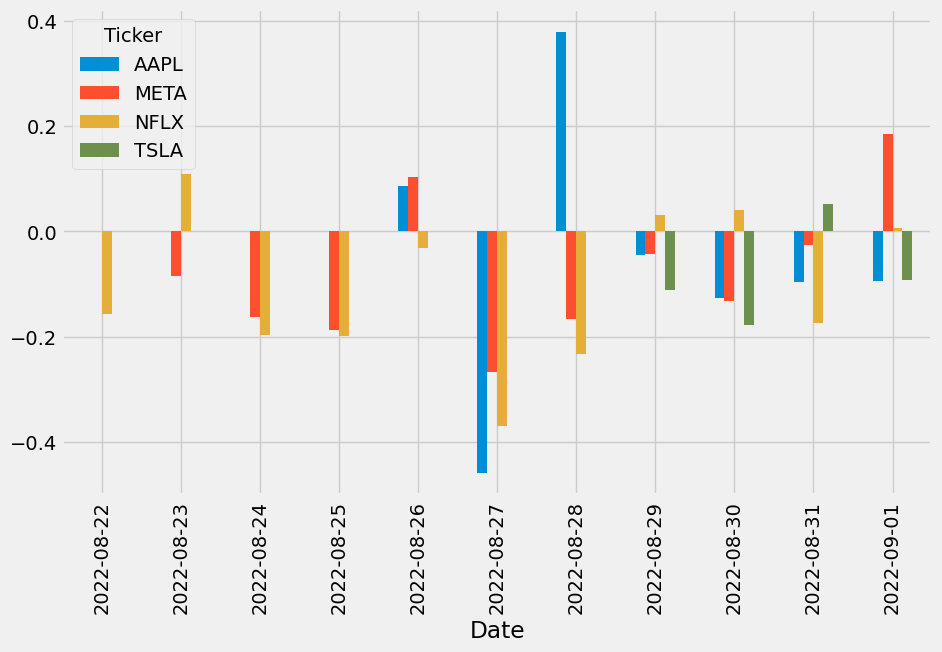

In [135]:
parsed_news_list = []

for url in url_list:
      driver = webdriver.Chrome()
      driver.get(url)

      html = driver.page_source.encode('utf-8').strip()
      soup = BeautifulSoup(html, "html.parser")

      news_tbl = soup.find(id= "news-table")
      
      # Finding all table rows from id: news-table
      source_tr = news_tbl.findAll('tr')

      
   
      for x in source_tr:
            ticker = soup.find('a', class_ = 'fullview-ticker', id='ticker').text

            headline = x.text

            date_scrape = x.td.text.split()

            
            if len(date_scrape) == 1:
                  time = date_scrape[0]
            else:
                  date = date_scrape[0]
                  time = date_scrape[1]
                  
                  
            parsed_news_list.append([ticker, headline, time, date])

driver.close()         
colnames = ['Ticker', 'Headline', 'Time', 'Date']  
    
parsed_news_df = pd.DataFrame(parsed_news_list, columns= colnames)

get_polarity_scores()

plot_sentiment_scores()


 <p>

 **Compound Score:** <br> is the sum of positive, negative, and neutral scores which is then normalized between -1 (most extreme negative) and +1 (most extreme positive). <br>
 The compund score being closer to +1 indicates the text to be higher positively. 
</p>

<p>
Create a label column to classify the overall headline's sentiment score
</p>

In [131]:
polar_scores_df['label'] = polar_scores_df['compound'].apply(lambda x: 
'Negative' if x <= -0.05
else ('Positve' if x >= 0.05 
else 'Neutral'))

polar_scores_df

,Ticker,Headline,Time,Date,neg,neu,pos,compound,label
0,TSLA,Sep-01-22 09:57PM Dow Jones Futures: Market R...,09:57PM,2022-09-01,0.000,1.000,0.000,0.0000,Neutral
1,TSLA,09:41PM Tesla Stock Vs. BYD Stock: EV Giant S...,09:41PM,2022-09-01,0.000,0.800,0.200,0.6124,Positve
2,TSLA,05:53PM Uber and Lyft Drivers in New York Str...,05:53PM,2022-09-01,0.150,0.850,0.000,-0.3182,Negative
3,TSLA,04:47PM Tesla Stock Took a Hit From Nvidias W...,04:47PM,2022-09-01,0.167,0.833,0.000,-0.3400,Negative
4,TSLA,04:31PM Li Autos August Deliveries Were Awful...,04:31PM,2022-09-01,0.295,0.705,0.000,-0.5574,Negative
...,...,...,...,...,...,...,...,...,...
419,AAPL,Aug-26-22 06:29PM Weekly Roundup TheStreet.com,06:29PM,2022-08-26,0.000,1.000,0.000,0.0000,Neutral
420,AAPL,"04:16PM Why Shopify, Amazon, and Apple Stocks...",04:16PM,2022-08-26,0.199,0.685,0.116,-0.2960,Negative
421,AAPL,04:11PM Justice Department reportedly draftin...,04:11PM,2022-08-26,0.000,0.764,0.236,0.5267,Positve
422,AAPL,"04:10PM Top Analyst Reports for Apple, Alibab...",04:10PM,2022-08-26,0.000,0.833,0.167,0.2023,Positve


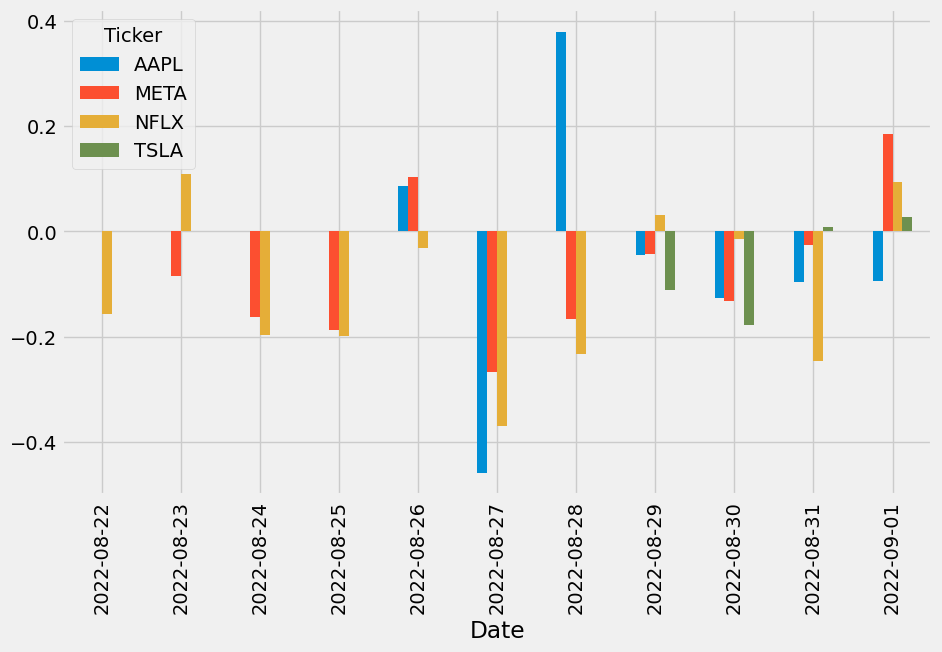

In [83]:
plot_sentiment_scores()

In [180]:
from matplotlib.pyplot import pie, show

label_count = {'Negative' : 0, 'Netural':0, 'Positive':0}

for i in polar_scores_df['label']:
   if i == 'Negative':
      label_count['Negative'] += 1
   elif i == 'Positive':
      label_count['Positive'] += 1
   else: label_count['Netural'] += 1

['Negative', 'Netural', 'Positive']
[182, 181, 149]


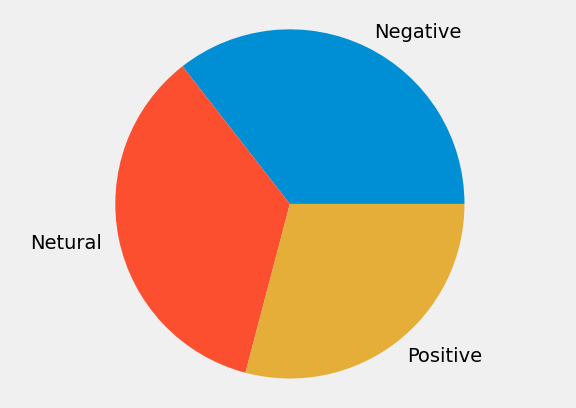

In [183]:
labels = []
sizes = []
for x, y in label_count.items():
   labels.append(x)
   sizes.append(y)

print('Labaels are: ', labels)
print('Sizes are: ', sizes)
plt.pie(sizes, labels= labels)

plt.axis('equal')
plt.show()

<h3> Method 2: </h3>

Using Saved Files in Our Directory to Get Sentiment Scores and Plot

In [161]:
html_webpage_tables = {}

# Iterate through our dataset folder
for table_name in os.listdir('webpage-html-set'):

    # Path of our file
    table_path = f'webpage-html-set/{table_name}'

    file = open(table_path, 'r', encoding='utf-8')

    # Read the contents of the file to create a soup object
    soup = BeautifulSoup(file)

    # Find id = news-table from our soup object
    news_tbl = soup.find(id='news-table')

    # Add the table to our dictionary
    html_webpage_tables[table_name] = news_tbl

In [158]:
# Hold the parsed news into a list
parsed_news_list = []

i = 0

# Iterate through the news
for file_name, news_table in html_webpage_tables.items():

    if i == 5:
        break
    
    # Only use 5 of our html files
    i += 1

    print('File Name:', file_name)

    # Iterate through all tr tags in the html page source with id = 'news-table'
    for x in news_table.findAll('tr'):

        # Read the text from the tr tag into text
        headline = x.text 
        # Split the text in the td tag into a list 
        date_scrape = x.td.text.split()
        

        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news_list.append([ticker, headline, date, time])


File Name: AAPL-Aug2022.html
File Name: AAPL-Sep2022.html
File Name: META-Aug2022.html
File Name: META-Sep2022.html
File Name: NFLX-Aug2022.html


In [160]:
# Use these column names
columns = ['Ticker', 'Headline', 'Date', 'Time']


# Convert the list of lists into a DataFrame
parsed_news_df = pd.DataFrame(parsed_news_list, columns=columns)

# Get the polarity scores
get_polarity_scores()


,Ticker,Headline,Date,Time,neg,neu,pos,compound
0,AAPL-Aug2022.html,Aug-29-22 05:42PM Why Globalstar Stock Soared...,2022-08-29,05:42PM,0.243,0.757,0.000,-0.5423
1,AAPL-Aug2022.html,04:46PM 10 Best ADR Stocks To Buy Now Insider...,2022-08-29,04:46PM,0.000,0.682,0.318,0.6369
2,AAPL-Aug2022.html,04:22PM Dow Jones Reverses; Elon Musk Makes T...,2022-08-29,04:22PM,0.856,0.144,0.000,-0.9993
3,AAPL-Aug2022.html,03:13PM 10 Best Index Funds Popular Among Red...,2022-08-29,03:13PM,0.000,0.562,0.438,0.7906
4,AAPL-Aug2022.html,02:24PM Apple Is Not Out of the Woods Just Ye...,2022-08-29,02:24PM,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...
507,NFLX-Aug2022.html,05:24PM Streaming viewership outpaced broadca...,2022-08-18,05:24PM,0.000,1.000,0.000,0.0000
508,NFLX-Aug2022.html,12:14PM Amazon is 'the dark horse' in streami...,2022-08-18,12:14PM,0.000,0.909,0.091,0.1779
509,NFLX-Aug2022.html,11:30AM Netflix (NFLX) Up 11.4% Since Last Ea...,2022-08-18,11:30AM,0.000,1.000,0.000,0.0000
510,NFLX-Aug2022.html,11:10AM Should You Really Buy Netflix Stock? ...,2022-08-18,11:10AM,0.182,0.818,0.000,-0.4404


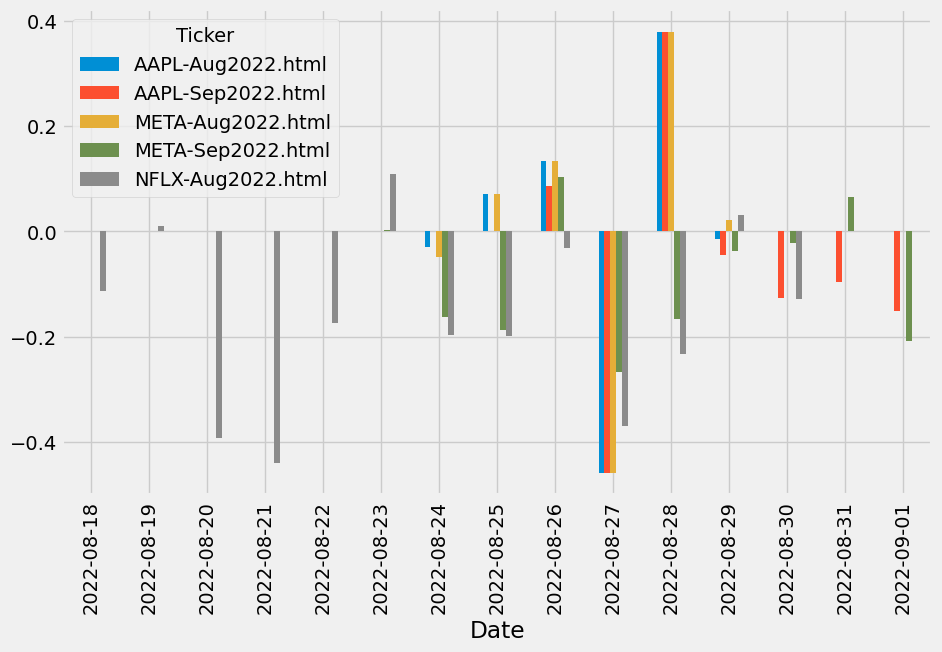

In [159]:
# Plotting our sentiment scores
plot_sentiment_scores()

In [174]:
polar_scores_df['label'] = polar_scores_df['compound'].apply(lambda x: 
'Negative' if x <= -0.05
else ('Positive' if x >= 0.05 
else 'Neutral'))

polar_scores_df

,Ticker,Headline,Date,Time,neg,neu,pos,compound,label
0,AAPL-Aug2022.html,Aug-29-22 05:42PM Why Globalstar Stock Soared...,2022-08-29,05:42PM,0.243,0.757,0.000,-0.5423,Negative
1,AAPL-Aug2022.html,04:46PM 10 Best ADR Stocks To Buy Now Insider...,2022-08-29,04:46PM,0.000,0.682,0.318,0.6369,Positive
2,AAPL-Aug2022.html,04:22PM Dow Jones Reverses; Elon Musk Makes T...,2022-08-29,04:22PM,0.856,0.144,0.000,-0.9993,Negative
3,AAPL-Aug2022.html,03:13PM 10 Best Index Funds Popular Among Red...,2022-08-29,03:13PM,0.000,0.562,0.438,0.7906,Positive
4,AAPL-Aug2022.html,02:24PM Apple Is Not Out of the Woods Just Ye...,2022-08-29,02:24PM,0.000,1.000,0.000,0.0000,Neutral
...,...,...,...,...,...,...,...,...,...
507,NFLX-Aug2022.html,05:24PM Streaming viewership outpaced broadca...,2022-08-18,05:24PM,0.000,1.000,0.000,0.0000,Neutral
508,NFLX-Aug2022.html,12:14PM Amazon is 'the dark horse' in streami...,2022-08-18,12:14PM,0.000,0.909,0.091,0.1779,Positive
509,NFLX-Aug2022.html,11:30AM Netflix (NFLX) Up 11.4% Since Last Ea...,2022-08-18,11:30AM,0.000,1.000,0.000,0.0000,Neutral
510,NFLX-Aug2022.html,11:10AM Should You Really Buy Netflix Stock? ...,2022-08-18,11:10AM,0.182,0.818,0.000,-0.4404,Negative


### Plotting a pie chart of all the label counts

In [175]:
from matplotlib.pyplot import pie, show

label_count = {'Negative' : 0, 'Netural':0, 'Positive':0}

for i in polar_scores_df['label']:
   if i == 'Negative':
      label_count['Negative'] += 1
   elif i == 'Positive':
      label_count['Positive'] += 1
   else: label_count['Netural'] += 1

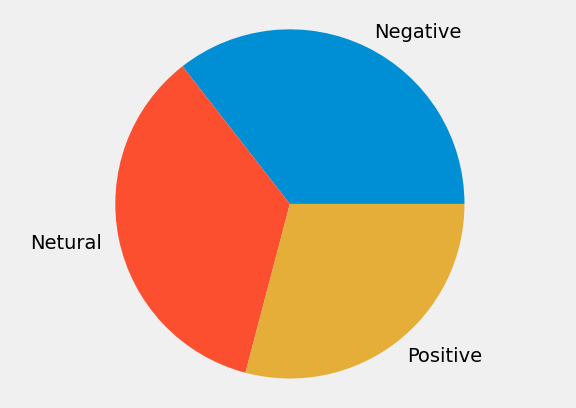

In [179]:
labels = []
sizes = []
for x, y in label_count.items():
   labels.append(x)
   sizes.append(y)

plt.pie(sizes, labels= labels)

plt.axis('equal')
plt.show()